# Economic Diversity and Student Outcomes

For #tidytuesday week 37, we are going to investigate the relationship between economic diversity and student outcomes in a dataset provided by [Havisha Khurana](https://github.com/havishak) via:

Org: [Opportunity Insights](https://opportunityinsights.org/data/)

Article: [Interactive visualization](https://www.nytimes.com/interactive/2017/01/18/upshot/some-colleges-have-more-students-from-the-top-1-percent-than-the-bottom-60.html)

[Interactive visualization here](https://www.nytimes.com/interactive/projects/college-mobility/university-of-texas-at-dallas)

Some information from the source:

> A new study, based on millions of anonymous tax records, shows that some colleges are even more economically segregated than previously understood, while others are associated with income mobility.

A key goal of this week's analysis has to do with what makes a dataset truly [tidy](https://r4ds.hadley.nz/data-tidy#sec-tidy-data):

1. Each variable is a column; each column is a variable.
2. Each observation is a row; each row is an observation.
3. Each value is a cell; each cell is a single value.

Let's go!

## Setup

In [1]:
# installation
using Pkg
Pkg.add(["DataFrames", "CSV", "HTTP", "StatsPlots",
    "StatsBase", "Plots", "SummaryTables", "DataFramesMeta",
    "Chain", "CategoricalArrays", "Measures", "PlotThemes"
])

# load
using DataFrames, CSV, HTTP, StatsPlots, StatsBase, Plots, SummaryTables, DataFramesMeta, Chain, CategoricalArrays, Measures, PlotThemes

    Updating registry at `C:\Users\ndfos\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\ndfos\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ndfos\.julia\environments\v1.10\Manifest.toml`


## Data

In [2]:
# Load the dataset
url = "https://opportunityinsights.org/wp-content/uploads/2023/07/CollegeAdmissions_Data.csv"

# file
response = HTTP.get(url)

# import
college_admissions = CSV.read(response.body, DataFrame);

In [3]:
# describe the raw DataFrame

describe(college_admissions)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,super_opeid,2528.51,108,2536.0,11649,0,Int64
2,name,,American University,,Yeshiva University,0,String
3,par_income_bin,78.1714,10.0,94.0,100.0,0,Float64
4,par_income_lab,,0-20,,Top 1,0,String7
5,attend,0.00482567,2.88504e-5,0.00303171,0.0460693,2,"Union{Missing, Float64}"
6,stderr_attend,0.000353691,0.0,0.000205173,0.00540242,0,Float64
7,attend_level,0.0040984,0.000420824,0.00256485,0.0201221,0,Float64
8,attend_sat,0.00400884,1.6128e-5,0.00235861,0.0423259,294,"Union{Missing, Float64}"
9,stderr_attend_sat,0.00048375,0.0,0.000313297,0.00374723,278,"Union{Missing, Float64}"


In [4]:
# how many unique parent income brackets are there?

length(unique(college_admissions.par_income_lab))

14

In [5]:
# see unique levels of the parent income labels

unique(college_admissions.par_income_lab)

14-element Vector{String7}:
 "0-20"
 "20-40"
 "40-60"
 "60-70"
 "70-80"
 "80-90"
 "90-95"
 "95-96"
 "96-97"
 "97-98"
 "98-99"
 "99-99.9"
 "Top 1"
 "Top 0.1"

## Cleaning

We'll clean the data similarly to the R code. Dropping the redundant "tier_name" variable and recoding the public and flagship columns.

In [6]:
college_admissions_clean = @chain begin
    college_admissions
    select(Not(:tier_name))  # Drop redundant variable
    transform(:public => ByRow(==("Public")) => :public)  # Recode public as boolean
    transform(:flagship => ByRow(Bool) => :flagship)  # Recode flagship as boolean
end

Row,super_opeid,name,par_income_bin,par_income_lab,attend,stderr_attend,attend_level,attend_sat,stderr_attend_sat,attend_level_sat,rel_apply,stderr_rel_apply,rel_attend,stderr_rel_attend,rel_att_cond_app,rel_apply_sat,stderr_rel_apply_sat,rel_attend_sat,stderr_rel_attend_sat,rel_att_cond_app_sat,attend_instate,stderr_attend_instate,attend_level_instate,attend_instate_sat,stderr_attend_instate_sat,attend_level_instate_sat,attend_oostate,stderr_attend_oostate,attend_level_oostate,attend_oostate_sat,stderr_attend_oostate_sat,attend_level_oostate_sat,rel_apply_instate,stderr_rel_apply_instate,rel_attend_instate,stderr_rel_attend_instate,rel_att_cond_app_instate,rel_apply_oostate,stderr_rel_apply_oostate,rel_attend_oostate,stderr_rel_attend_oostate,rel_att_cond_app_oostate,rel_apply_instate_sat,stderr_rel_apply_instate_sat,rel_attend_instate_sat,stderr_rel_attend_instate_sat,rel_att_cond_app_instate_sat,rel_apply_oostate_sat,stderr_rel_apply_oostate_sat,rel_attend_oostate_sat,stderr_rel_attend_oostate_sat,rel_att_cond_app_oostate_sat,attend_unwgt,stderr_attend_unwgt,attend_unwgt_level,attend_unwgt_instate,stderr_attend_unwgt_instate,attend_unwgt_oostate,stderr_attend_unwgt_oostate,attend_unwgt_level_instate,attend_unwgt_level_oostate,rel_attend_unwgt,rel_apply_unwgt,stderr_rel_attend_unwgt,stderr_rel_apply_unwgt,rel_att_cond_app_unwgt,rel_attend_unwgt_instate,rel_attend_unwgt_oostate,stderr_rel_attend_unwgt_instate,stderr_rel_attend_unwgt_oostate,rel_apply_unwgt_instate,rel_apply_unwgt_oostate,stderr_rel_apply_unwgt_instate,stderr_rel_apply_unwgt_oostate,rel_att_cond_app_unwgt_instate,rel_att_cond_app_unwgt_oostate,public,flagship,tier,test_band_tier
,Int64,String,Float64,String7,Float64?,Float64,Float64,Float64?,Float64?,Float64,Float64,Float64,Float64?,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64,Float64,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Bool,Bool,String,String31
1,1434,American University,10.0,0-20,0.00112245,0.000120323,0.00160867,0.00136137,0.000236315,0.00153681,0.666447,0.0264994,0.697747,0.0747965,1.04696,0.731501,0.0527265,0.885841,0.15377,1.21099,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.000265268,2.0233e-5,0.000677089,missing,missing,missing,missing,missing,missing,0.391777,0.337474,0.0298824,0.00951032,1.16091,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,false,false,Highly selective private,Other Top 100 Private
2,1434,American University,30.0,20-40,0.00100459,9.40779e-5,0.00160867,0.0020623,0.000166899,0.00153681,0.680798,0.0209366,0.624483,0.0584816,0.917281,0.762442,0.042126,1.34194,0.108601,1.76005,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.000262136,1.70005e-5,0.000677089,missing,missing,missing,missing,missing,missing,0.387151,0.392894,0.0251083,0.00866705,0.985385,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,false,false,Highly selective private,Other Top 100 Private
3,1434,American University,50.0,40-60,0.00140801,8.23569e-5,0.00160867,0.00143021,0.00015032,0.00153681,0.70235,0.0155977,0.875261,0.0511955,1.24619,0.691192,0.0291178,0.930637,0.0978131,1.34642

## Pivot the Data
Now, we can use the `@chain` macro for both long and wide pivoting operations.

### Long Format

In [7]:
long_college_admissions = @chain begin
    college_admissions_clean
    stack([:rel_attend, :rel_apply])
end

describe(long_college_admissions)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,super_opeid,2528.51,108,2536.0,11649,0,Int64
2,name,,American University,,Yeshiva University,0,String
3,par_income_bin,78.1714,10.0,94.0,100.0,0,Float64
4,par_income_lab,,0-20,,Top 1,0,String7
5,attend,0.00482567,2.88504e-5,0.00303171,0.0460693,4,"Union{Missing, Float64}"
6,stderr_attend,0.000353691,0.0,0.000205173,0.00540242,0,Float64
7,attend_level,0.0040984,0.000420824,0.00256485,0.0201221,0,Float64
8,attend_sat,0.00400884,1.6128e-5,0.00235861,0.0423259,588,"Union{Missing, Float64}"
9,stderr_attend_sat,0.00048375,0.0,0.000313297,0.00374723,556,"Union{Missing, Float64}"


### Wide Format

In [8]:
wide_college_admissions = @chain college_admissions_clean begin
    unstack(:par_income_bin, :attend)
end

describe(wide_college_admissions)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,super_opeid,2528.51,108,2536.0,11649,0,Int64
2,name,,American University,,Yeshiva University,0,String
3,par_income_lab,,0-20,,Top 1,0,String7
4,stderr_attend,0.000353691,0.0,0.000205173,0.00540242,0,Float64
5,attend_level,0.0040984,0.000420824,0.00256485,0.0201221,0,Float64
6,attend_sat,0.00400884,1.6128e-5,0.00235861,0.0423259,294,"Union{Missing, Float64}"
7,stderr_attend_sat,0.00048375,0.0,0.000313297,0.00374723,278,"Union{Missing, Float64}"
8,attend_level_sat,0.00351086,0.000398661,0.00213691,0.0188583,0,Float64
9,rel_apply,1.17263,0.0704434,1.04823,5.8736,0,Float64


## Next steps!

Now, we have a cleaned dataset and both long and wide pivots.  Let's create a visualization for both formats that can help us understand economic diversity and student outcomes.

## Visualization 1: Long Format (`rel_attend`)
We can use a combination of a horizontal boxplot with a jittered scatterplot to visualize the distribution of the `rel_attend` values across schools, grouped by the income bins or tiers, for example. This will provide insights into the spread and outliers within each group.

### Plot Type: Horizontal barplot grouped by parent income bin
* Theme: `vibrant` from `PlotThemes.jl`

### Insights via the Long Format

In [9]:
function plot_long_format(df)
    theme(:gruvbox_light)  # Apply vibrant theme

    # Filter out "Top 0.1" and "Top 1" from :par_income_lab
    df_filter = @chain begin
        df
        filter(:par_income_lab => x -> !(x in ["Top 0.1", "Top 1"]), _)
    end

    # Plotting side-by-side bars with divisions based on `:variable`
    @df df_filter groupedbar(:par_income_lab, :value,
        group= :variable,
        title="Student Relative Attendance and Application Rates Are Clearly a Function of Parent Income\n\nSource: Opportunity Insights | College Student Attendance/Application Data\n\n",
        xlabel="Income Bin", 
        ylabel="Relative Metric",
        permute=(:x, :y),
        size = (800, 600),
        grid = false,
        titlefontsize = 10,
        titlealign = :left,
        legend = :outertopright,
        labels = ["Relative Application Rate to Mean" "Relative Attendance Rate to Mean"]
        )
yflip!()
   
end

plot_long_format (generic function with 1 method)

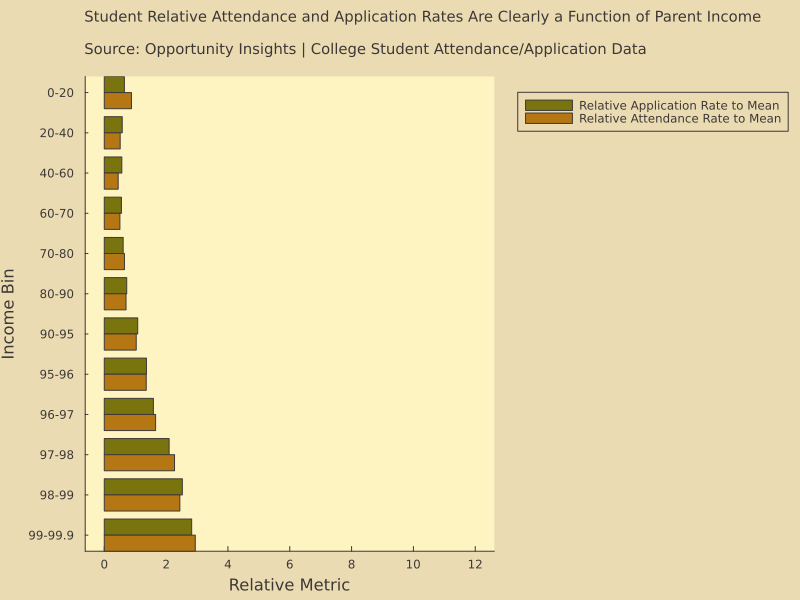

In [10]:
# plot long format 

plot_long_format(long_college_admissions)

In [11]:
# another view

function plot_long_new(df)
    theme(:bright)  # Apply the desired theme

    # Filter out "Top 0.1" and "Top 1" from :par_income_lab
    df_filtered = @chain begin
        df
        filter(:par_income_lab => x -> !(x in ["Top 0.1", "Top 1"]), _)
    end

    # Calculate the percentages for each :par_income_lab based on :tier
    df_normalized = @chain begin
        df_filtered
        groupby([:par_income_lab, :tier])  # Group by parent income and tier
        combine(:tier => length => :total_value)  # Sum values within each group
        groupby(:par_income_lab)
        @transform(:percent_value = :total_value ./ sum(:total_value))  # Normalize to 100%
    end

    # Create the 100% stacked bar plot
    @df df_normalized groupedbar(:par_income_lab, :percent_value,
        group=:tier,
        bar_position=:stack,  # Ensure bars are stacked for 100% representation
        title="Relative Attendance and Application Rates by Parent Income Bin",
        xlabel="Income Bin",
        ylabel="Percentage (%)",
        size=(800, 600),
        grid=false,
        titlefontsize=20,
        titlealign=:left,
        legend=:outertopright
    )

    # Flip the y-axis if desired
    yflip!()
end

plot_long_new (generic function with 1 method)

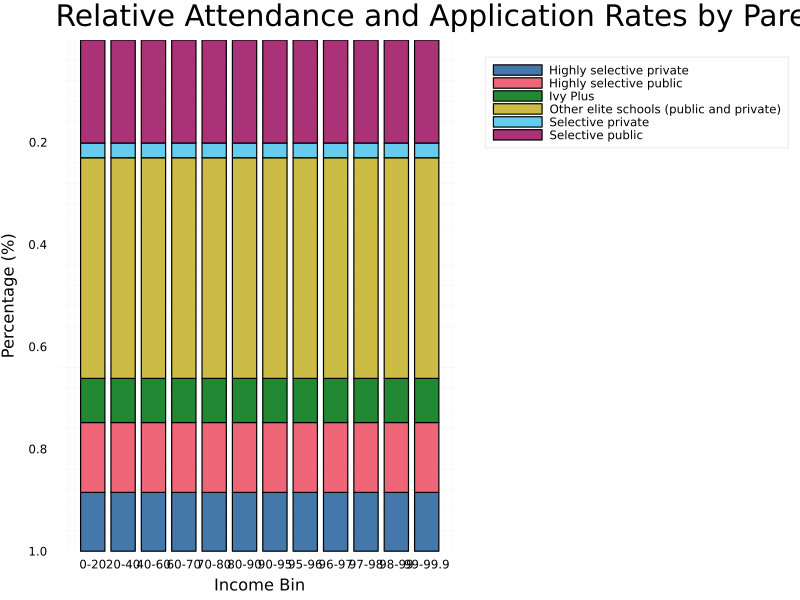

In [12]:
# plot new format

plot_long_new(college_admissions_clean)

In [13]:
unique(college_admissions_clean.par_income_bin)

14-element Vector{Float64}:
  10.0
  30.0
  50.0
  65.0
  75.0
  85.0
  92.5
  95.5
  96.5
  97.5
  98.5
  99.400002
  99.5
 100.0

In [14]:
@chain begin
    college_admissions_clean
    filter(:tier => x -> x == "Highly selective private", _)
    groupby([:par_income_bin, :tier])  # Group by parent income and tier
    combine(:attend => sum => :total_attendance,
    )  # Sum relative attendance within each group
    combine(:total_attendance => sum => :total
    )
end


Row,total
,Float64
1,0.658039


In [15]:
@chain begin
    college_admissions_clean
    groupby([:par_income_lab, :tier])  # Group by parent income and tier
    combine(:par_income_lab => length => :total_value)  # Sum values within each group
end

Row,par_income_lab,tier,total_value
,String7,String,Int64
1,0-20,Highly selective private,16
2,0-20,Other elite schools (public and private),60
3,0-20,Selective public,28
4,0-20,Highly selective public,19
5,0-20,Selective private,4
6,0-20,Ivy Plus,12
7,20-40,Highly selective private,16
8,20-40,Other elite schools (public and private),60
9,20-40,Selective public,28


In [16]:
@chain begin
    college_admissions_clean
    groupby([:par_income_lab, :tier])  # Group by parent income and tier
    combine(:tier => length => :total_value; ungroup = true)  # Sum values within each group
    groupby(:tier)
    @transform(:group_total = sum(:total_value))
    @transform(:percent_value = :total_value ./ :group_total)  # Normalize to 100%
end

Row,par_income_lab,tier,total_value,group_total,percent_value
,String7,String,Int64,Int64,Float64
1,0-20,Highly selective private,16,224,0.0714286
2,0-20,Other elite schools (public and private),60,840,0.0714286
3,0-20,Selective public,28,392,0.0714286
4,0-20,Highly selective public,19,266,0.0714286
5,0-20,Selective private,4,56,0.0714286
6,0-20,Ivy Plus,12,168,0.0714286
7,20-40,Highly selective private,16,224,0.0714286
8,20-40,Other elite schools (public and private),60,840,0.0714286
9,20-40,Selective public,28,392,0.0714286


## Visualization 2: Wide Format (attend)
For the wide format, we can visualize the attend variable using a bar plot. We could group the schools by their selectivity tier or another categorical variable and display the attendance rates.

Plot Type: Bar plot
* Theme: `bright` from `PlotThemes.jl`
* Font: 'Work Sans'
* Data labels: Include labels on each bar, showing attendance rates for clarity

Here’s the structure of the code to achieve this in Julia using `Makie.jl` for plotting:

### Insights via the Wide Format

In [17]:
# plot the wide college admissions 

plot_wide_format(wide_college_admissions)

UndefVarError: UndefVarError: `plot_wide_format` not defined